## Task 1
### Solving ordinary differential equation of the second order by finite difference method

Equation:<br/>
$ -p(x) u''(x) + q(x) u'(x) + r(x) u(x) = f(x) $

x $ \in (a, b) $

Boundary values: <br/>
$ \alpha_{1}u(a) − \alpha_{2}u′(a) = \alpha, |\alpha_{1}| + |\alpha_{2}| \neq 0, \alpha_{1}\alpha_{2} ≥ 0, $ <br/>
$ \beta_{1}u(b) + \beta_{2}u′(b) = \beta, |\beta_{1}| + |\beta_{2}| \neq 0, \beta_{1}\beta_{2} ≥ 0. $


In [165]:
import numpy as np
from typing import Tuple, Callable
from math import e, sin, cos, log
import matplotlib.pyplot as plt
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix

Function = Callable[[float], float]
Grid = Tuple[np.ndarray, float]
BoundaryValue = Tuple[float, float, float]

#### Solves linear algebraic systems with tridiagonal matrix
Uses [tridiagonal matrix algorighm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm)


In [125]:
def solve_tridiagonal_system(matrix: np.ndarray, right_part: np.ndarray) -> np.ndarray:
    n = matrix.shape[0]
    alphas = [-1 * matrix[0][1] / matrix[0][0]]
    betas = [right_part[0] / matrix[0][0]]

    # The forward sweep
    for i in range(1, n):
        y = matrix[i, i] + matrix[i, i - 1] * alphas[i - 1]
        if i < n - 1:
            alphas.append(-1 * matrix[i, i + 1] / y)
        betas.append((right_part[i] - matrix[i, i - 1] * betas[i - 1]) / y)

    # Back substitution
    result = [betas[n - 1]]
    for i in range(n - 2, -1, -1):
        result.insert(0, alphas[i] * result[0] + betas[i])
    return np.array(result)

In [126]:
def get_true_error_norm(true_solution: np.ndarray, actual_solution: np.ndarray) -> float:
    return abs(true_solution - actual_solution).max()

In [136]:
def get_richardson_error(curr_solution: np.ndarray, next_solution: np.ndarray) -> float:
    error_by_even_points = abs(next_solution[::2] - curr_solution) / 3

    max_error = -1
    for left_error, right_error in zip(error_by_even_points, error_by_even_points[1:]):
        max_error = max(max_error, left_error, right_error, (left_error + right_error) / 2)
    return max_error

#### Transforms differential equation into an equal algebraic system

The method is based on replacing derivative with finite differences of $O(h^{2})$ order.
An approximated function is represented by values in points of the grid.

In [152]:
def solve_equation(
        p: Function,
        q: Function,
        r: Function,
        f: Function,
        grid: Grid,
        left_boundary_value: BoundaryValue,
        right_boundary_value: BoundaryValue
        ) -> np.ndarray:
    alpha_1, alpha_2, alpha = left_boundary_value
    beta_1, beta_2, beta = right_boundary_value

    points, step = grid
    n = len(points)

    matrix = np.zeros((n, n))
    right_part = np.zeros(n)

    # first row, left bounday values
    matrix[0][0] = alpha_1 + 3 / (2 * step) * alpha_2
    matrix[0][1] = -2 * alpha_2 / step
    matrix[0][2] = alpha_2 / (2 * step)
    right_part[0] = alpha

     ## Finite differences for inner points of the grid
    for index in range(1, n - 1):
        point = points[index]

        matrix[index][index - 1] = p(point) / (step ** 2) - q(point) / (2 * step)
        matrix[index][index] = -2 / (step ** 2) - r(point)
        matrix[index][index + 1] = p(point) / (step ** 2) + q(point) / (2 * step)
        right_part[index] = f(point)

    matrix[n - 1][n - 3] = beta_2 / (2 * step)
    matrix[n - 1][n - 2] = -2 * beta_2 / step
    matrix[n - 1][n - 1] = beta_1 + 3 * beta_2 / (2 * step)
    right_part[n - 1] = beta

    is_tridiagonal = alpha_2 == 0 and beta_2 == 0
    
    return solve_tridiagonal_system(matrix, right_part) if is_tridiagonal else spsolve(csc_matrix(matrix), right_part)

In [140]:
def solve_equation_with_accuracy(
        a: float,
        b: float,
        p: Function,
        q: Function,
        r: Function,
        f: Function,
        left_boundary_value: BoundaryValue,
        right_boundary_value: BoundaryValue,
        epsilon: float) -> dict:
    grid_size = 4
    grid = np.linspace(a, b, grid_size, retstep=True)
    next_solution = solve_equation(p, q, r, f, grid, left_boundary_value, right_boundary_value)
    error = float("inf")
    grid_sizes = []
    errors = []
    while error >= epsilon:
        current_solution = next_solution
        grid_size = grid_size * 2 - 1
        grid = np.linspace(a, b, grid_size, retstep=True)
        next_solution = solve_equation(p, q, r, f, grid, left_boundary_value, right_boundary_value) 
        error =  get_richardson_error(current_solution, next_solution)
        grid_sizes.append(grid_size)
        errors.append(error)
    
    result = {}
    result["solution"] = next_solution
    result["grid"] = grid
    result["grid_sizes"] = grid_sizes
    result["errors"] = errors
    
    return result 

In [162]:
def run_test(p, q, r, f, a, b, left_boundary_value, right_boundary_value, epsilon, u=None):
    result = solve_equation_with_accuracy(a, b, p, q, r, f, left_boundary_value, right_boundary_value, epsilon)
    points, step = result["grid"]
    
    if u is not None:
        true_solution = []
        for point in points:
            true_solution.append(u(point))
        true_error = get_true_error_norm(true_solution, result["solution"])

        print("Real Error: ", true_error)
    
    print("Last Error: ", result["errors"][-1])
    print("Last Grid Size: ", len(points))
    print("Last Step: ", step)

    plt.figure(figsize=(6, 3))
    plt.loglog(result["grid_sizes"], result["errors"], label='Errors', color='red')
    plt.xlabel('grid size')
    plt.ylabel('error norm')
    plt.grid()
    plt.title('Errors')
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(points, result["solution"], label='Result', color='blue')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.title('Result')
    plt.show()

### Test 1
#### Simple conditions

$ u = xe^{sin(x)} $ </br>
$ u(-1) = -e^{sin(-1)} $ </br>
$ u(2) = 2e^{sin(2)} $

$ \varepsilon = 10^{-8} $

Real Error:  5.43996581114925e-09
Last Error:  5.7865812882103756e-09
Last Grid Size:  24577
Last Step:  0.0001220703125


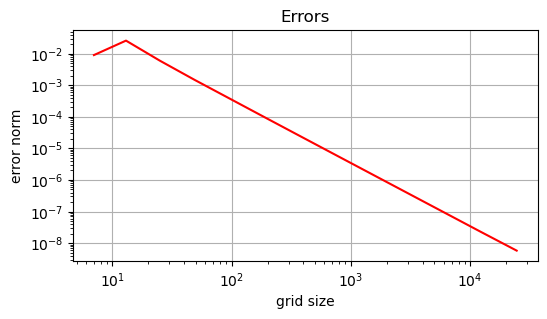

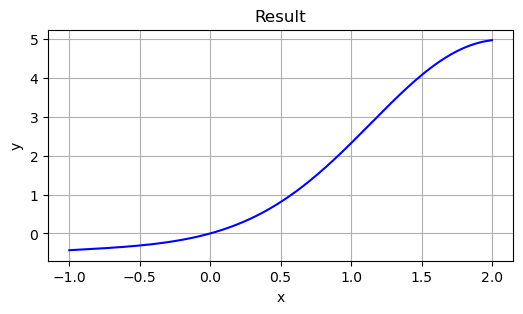

In [163]:
u = lambda x: x * e ** sin(x)
du = lambda x: e ** sin(x) * (x * cos(x) + 1)
ddu = lambda x: e ** sin(x) * (-x * sin(x) + x * cos(x) ** 2 + 2 * cos(x))

p = lambda x: 1
q = lambda x: -x
r = lambda x: 1
f = lambda x: ddu(x) + q(x) * du(x) - r(x) * u(x)

a = -1
b = 2

alpha_1 = 1
alpha_2 = 0
alpha = a * e ** sin(a)

left_boundary_value = (alpha_1, alpha_2, alpha)

beta_1 = 1
beta_2 = 0
beta = b * e ** sin(b)

right_boundary_value = (beta_1, beta_2, beta)

epsilon = 1 / 100000000

run_test(p, q, r, f, a, b, left_boundary_value, right_boundary_value, epsilon, u)

### Test 2
#### General conditions

$ u(x) = x^{5} - 5x^{4} + 5x^{3} + 5x^{2} - 6x $ </br>
$ 2u(-1) + 3u'(-1) = -24 $ </br>
$ 3u(3) + \frac{3}{8}u'(3) = 3 $

$ \varepsilon = 10^{-5} $

Real Error:  4.490589657457633e-06
Last Error:  4.488756174758635e-06
Last Grid Size:  12289
Last Step:  0.0003255208333333333


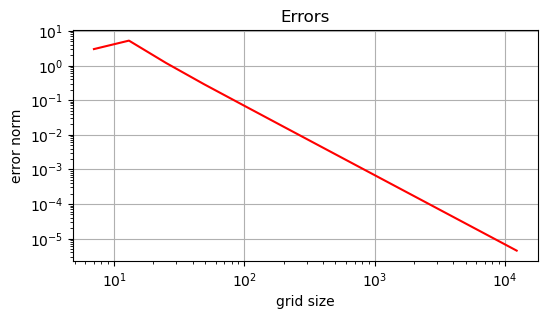

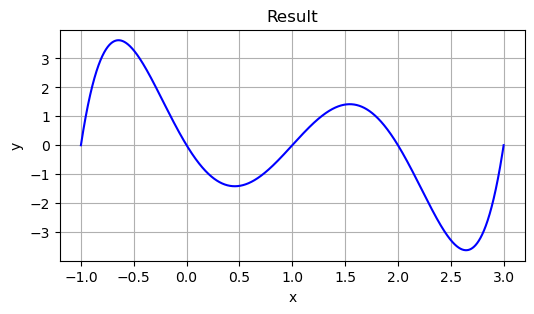

In [164]:
u = lambda x: x ** 5 - 5 * x ** 4 + 5 * x ** 3 + 5 * x ** 2 - 6 * x
du = lambda x: 5 * x ** 4 - 20 * x ** 3 + 15 * x ** 2 + 10 * x - 6
ddu = lambda x: 10 * (2 * x ** 3 - 6 * x ** 2 + 3 * x + 1)

p = lambda x: 1
q = lambda x: 5
r = lambda x: -x
f = lambda x: ddu(x) + q(x) * du(x) - r(x) * u(x)

a = -1
b = 3

alpha_1 = 2
alpha_2 = 1
alpha = -24

left_boundary_value = (alpha_1, alpha_2, alpha)

beta_1 = 3
beta_2 = 1 / 8
beta = 3

right_boundary_value = (beta_1, beta_2, beta)

epsilon = 1 / 100000

run_test(p, q, r, f, a, b, left_boundary_value, right_boundary_value, epsilon, u)

### Test 3
#### Pakulina (6)

Last Error:  4.924449237131307e-06
Last Grid Size:  1537
Last Step:  0.0013020833333333333


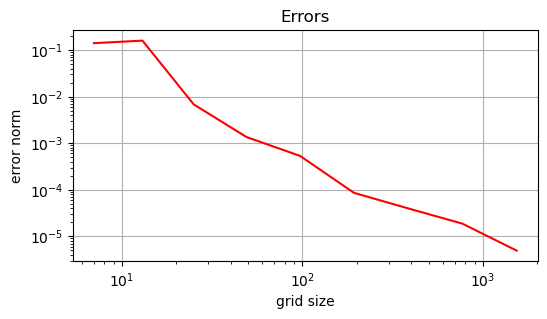

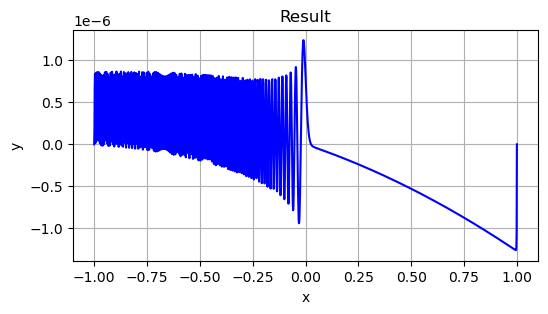

In [166]:
p = lambda x: (2 - x) / (x + 2)
q = lambda x: x
r = lambda x: 1 - sin(x)
f = lambda x: x ** 2

a = -1
b = 1

alpha_1 = 1
alpha_2 = 0
alpha = 0

left_boundary_value = (alpha_1, alpha_2, alpha)

beta_1 = 1
beta_2 = 0
beta = 0

right_boundary_value = (beta_1, beta_2, beta)

epsilon = 1 / 100000

run_test(p, q, r, f, a, b, left_boundary_value, right_boundary_value, epsilon)